### <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#006600; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #003300"> 📜 Notebook At a Glance</p>

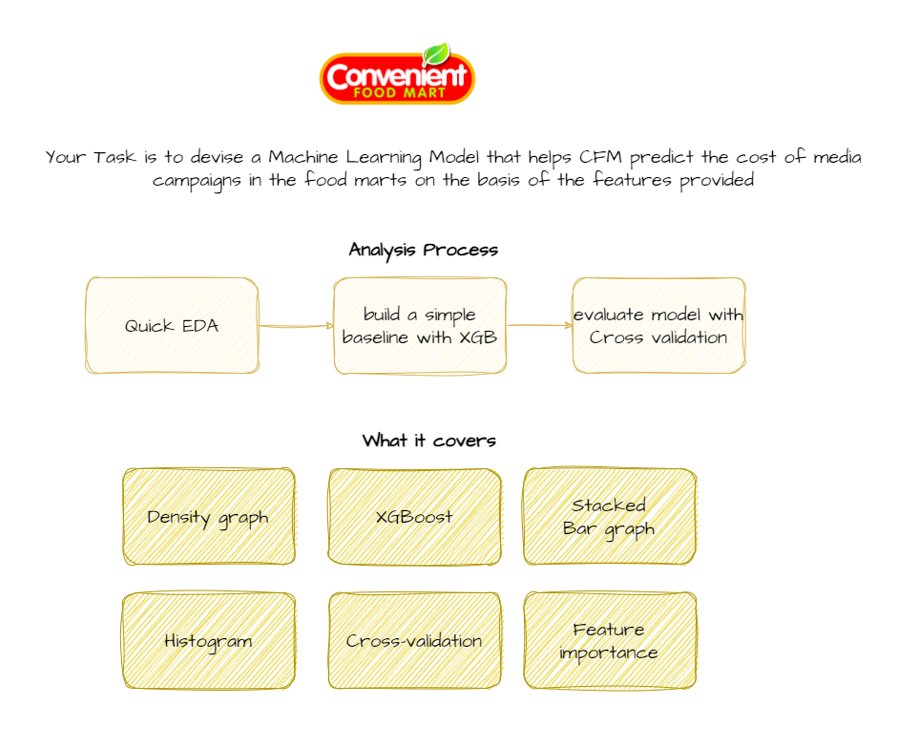

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left">

<h3 align="left"><font color='#DEB887'>📊 Data description:</font></h3>

* store_sales(in millions) - store_sales(in million dollars)
* unit_sales(in millions) - unit_sales(in millions) in stores Quantity
* Total_children - TOTAL CHILDREN IN HOME
* avg_cars_at home(approx) - avg_cars_at home(approx)
* Num_children_at_home - num_children_at_home AS PER CUSTOMERS FILLED DETAILS
* Gross_weight - gross_weight OF ITEM
* Recyclable_package - FOOD ITEM IS recyclable_package
* Low_fat - LOW_FAT FOOD ITEM IS LOW FAT
* Units_per_case - UNITS/CASE UNITS AVAILABLE IN EACH STORE SHELVES
* Store_sqft - STORE AREA AVAILABLE IN SQFT
* Coffee_bar - COFFEE BAR available in store
* Video_store - VIDEO STORE/gaming store available
* Salad_bar - SALAD BAR available in store
* Prepared_food - food prepared available in store
* Florist - flower shelves available in store
* Cost - COST ON ACQUIRING A CUSTOMERS in dollars
    
**Your Task is to devise a Machine Learning Model that helps us predict the cost of media campaigns in the food marts on the basis of the features provided.**

In [ ]:
!wget http://bit.ly/3ZLyF82 -O CSS.css -q
    
from IPython.core.display import HTML
with open('./CSS.css', 'r') as file:
    custom_css = file.read()

HTML(custom_css)

# Thanks for the idea of CSS @SERGEY SAHAROVSKIY
# Please refer to https://www.kaggle.com/code/sergiosaharovskiy/ps-s3e7-2023-eda-and-submission

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gc

from tqdm.auto import tqdm
import math
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GridSearchCV
import warnings
warnings.filterwarnings('ignore')


from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

tqdm.pandas()

rc = {
    "axes.facecolor": "#FFF9ED",
    "figure.facecolor": "#FFF9ED",
    "axes.edgecolor": "#000000",
    "grid.color": "#EBEBE7",
    "font.family": "serif",
    "axes.labelcolor": "#000000",
    "xtick.color": "#000000",
    "ytick.color": "#000000",
    "grid.alpha": 0.4
}

sns.set(rc=rc)

from colorama import Style, Fore
red = Style.BRIGHT + Fore.RED
blu = Style.BRIGHT + Fore.BLUE
mgt = Style.BRIGHT + Fore.MAGENTA
gld = Style.BRIGHT + Fore.YELLOW
res = Style.RESET_ALL


In [ ]:
train = pd.read_csv("/kaggle/input/playground-series-s3e11/train.csv")
test = pd.read_csv("/kaggle/input/playground-series-s3e11/test.csv")
original = pd.read_csv("/kaggle/input/media-campaign-cost-prediction/train_dataset.csv")

### <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#006600; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #003300">Brief EDA</p>

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left">

<h3 align="left"><font color='#DEB887'>💡 Summary of EDA:</font></h3>

* There are 16 X variables and 1 target(y) variable, while 1 variable(id) is extra data
    
* No missing values on each columns~!
    
* All variables are float64 type. However please note that some of them are categorical variables!

* The size of synthetic dataset is much bigger than original one. Therefore, no need to add original dataset (but I added...)

In [ ]:
# summary table function
def summary(df):
    print(f'data shape: {df.shape}')
    summ = pd.DataFrame(df.dtypes, columns=['data type'])
    summ['#missing'] = df.isnull().sum().values * 100
    summ['%missing'] = df.isnull().sum().values / len(df)
    summ['#unique'] = df.nunique().values
    desc = pd.DataFrame(df.describe(include='all').transpose())
    summ['min'] = desc['min'].values
    summ['max'] = desc['max'].values
    summ['first value'] = df.loc[0].values
    summ['second value'] = df.loc[1].values
    summ['third value'] = df.loc[2].values
    
    return summ

In [ ]:
summary(train)

In [ ]:
summary(test)

In [ ]:
summary(original)

In [ ]:
# select numerical and categorical variables respectively.
num_cols = test.select_dtypes(include=['float64','int64']).columns.tolist()
num_cols.remove('id')

In [ ]:
sns.displot(train, x="cost", kde=True)

> #### ✔️ target value is not normally distributed. But not skewed at all.

> #### 📊 let's check the distribution of each X variables.

In [ ]:

features = num_cols
n_bins = 50
histplot_hyperparams = {
    'kde':True,
    'alpha':0.4,
    'stat':'percent',
    'bins':n_bins
}

columns = features
n_cols = 4
n_rows = math.ceil(len(columns)/n_cols)
fig, ax = plt.subplots(n_rows, n_cols, figsize=(20, n_rows*4))
ax = ax.flatten()

for i, column in enumerate(columns):
    plot_axes = [ax[i]]
    sns.kdeplot(
        train[column], label='Train',
        ax=ax[i], color='#9E3F00'
    )
    
    sns.kdeplot(
        test[column], label='Test',
        ax=ax[i], color='yellow'
    )
    
#     sns.kdeplot(
#         original[column], label='Original',
#         ax=ax[i], color='#20BEFF'
#     )
    
    # titles
    ax[i].set_title(f'{column} Distribution');
    ax[i].set_xlabel(None)
    
    # remove axes to show only one at the end
    plot_axes = [ax[i]]
    handles = []
    labels = []
    for plot_ax in plot_axes:
        handles += plot_ax.get_legend_handles_labels()[0]
        labels += plot_ax.get_legend_handles_labels()[1]
        plot_ax.legend().remove()
    
for i in range(i+1, len(ax)):
    ax[i].axis('off')
    
fig.suptitle(f'Numerical Feature Distributions\n\n\n', ha='center',  fontweight='bold', fontsize=25)
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.96), fontsize=25, ncol=3)
plt.tight_layout()

# kudos to @jcaliz /  
# refer to https://www.kaggle.com/code/sergiosaharovskiy/ps-s3e7-2023-eda-and-submission

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left">

<h3 align="left"><font color='#DEB887'>💡 Insights:</font></h3>

* There are many ordinal and categorical variables!!! 
  
* 'total_children', 'num_children_at_home', 'avg_cars_at home(approx).1', 'recyclable_package', 'low_fat', 'coffee_bar', 'video_store', 'salad_bar', 'prepared_food','florist' these variables are should be analyzed in a different way.

In [ ]:
fig, ax = plt.subplots(3,4, figsize=(25,14), dpi=150)
ax = ax.flatten()
for i, ft in enumerate(['total_children', 'num_children_at_home', 'avg_cars_at home(approx).1', 'recyclable_package', 'low_fat', 
       'coffee_bar', 'video_store', 'salad_bar', 'prepared_food','florist']):
    sns.histplot(
        data=train,
        x="cost", hue=ft,
        multiple="stack",
        palette="dark:blue",
        edgecolor=".3",
        linewidth=.5,
        log_scale=True,
        ax=ax[i]
    )
fig.suptitle(f'Categorical Features and its Price\n\n', ha='center',  fontweight='bold', fontsize=24)
plt.tight_layout()
plt.show()

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left">

<h3 align="left"><font color='#DEB887'>💡 Insights:</font></h3>

* All of these variables seems useful as it shows different distributions, which indicates that thses variables have predictive power.

In [ ]:
def plot_correlation_heatmap(df: pd.core.frame.DataFrame, title_name: str='Train correlation') -> None:
    corr = df.corr()
    fig, axes = plt.subplots(figsize=(20, 10))
    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask)] = True
    sns.heatmap(corr, mask=mask, linewidths=.5, cmap='YlOrRd', annot=True)
    plt.title(title_name)
    plt.show()

plot_correlation_heatmap(train, 'Train Dataset Correlation')
plot_correlation_heatmap(test, 'Test Dataset Correlation')


### <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#006600; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #003300">Baseline modeling with XGB</p>

In [ ]:
train.drop('id',axis=1, inplace=True)
df = pd.concat([train, original])

In [ ]:
# create dummies with categorical variables
X = df.drop('cost',axis=1)
Y = df['cost']

In [ ]:
test.set_index('id',inplace=True)

<div class="alert alert-block alert-success" style="font-size:14px; font-family:verdana; line-height: 1.7em;">
    📌 &nbsp;<b><u>modeling overview:</u></b><br>
    
* <i> build baseline model without hyperparameter tuning.</i><br>
* <i> 3-fold cross validation methods are used for baseline modeling.</i><br>
* <i> Evalution metric is Root Mean Squared Error</i><br>
    
</div>

In [ ]:
from sklearn.metrics import mean_squared_log_error

cv_scores = list()
importance_xgb = list()
preds = list()

## Running 3 fold CV
for i in range(3):
    print(f'{i} fold cv begin')
    skf = KFold(n_splits = 3, random_state = 1004, shuffle = True)
    
    for train_ix, test_ix in skf.split(X, Y):
        
        ## Splitting the data 
        X_train, X_test = X.iloc[train_ix], X.iloc[test_ix]
        Y_train, Y_test = Y.iloc[train_ix], Y.iloc[test_ix]
                
        ## Building RF model
        XGB_md = XGBRegressor(tree_method = 'gpu_hist',
                              colsample_bytree = 0.8, 
                              gamma = 0.8, 
                              learning_rate = 0.01, 
                              max_depth = 6, 
                              min_child_weight = 10, 
                              n_estimators = 1000, 
                              subsample = 0.8).fit(X_train, Y_train)
        importance_xgb.append(XGB_md.feature_importances_)
        
        XGB_pred_1 = XGB_md.predict(X_test)
        XGB_pred_2 = XGB_md.predict(test)
        
        # Calculate RMSE
        cv_scores.append(mean_squared_log_error(Y_test, XGB_pred_1, squared = False))
        preds.append(XGB_pred_2)
        print(f'{i} fold cv done')

scores = np.mean(cv_scores)    
print('The average RMSE over 3-folds (run 3 times) is:', scores)

> ##### It is the Root Mean Squared Error of the log-transformed predicted and log-transformed actual values.

> ##### RMSLE adds 1 to both actual and predicted values before taking the natural logarithm to avoid taking the natural log of possible 0 (zero) values.

> ##### As a result, the function can be used if actual or predicted have zero-valued elements. But this function is not appropriate if either is negative valued

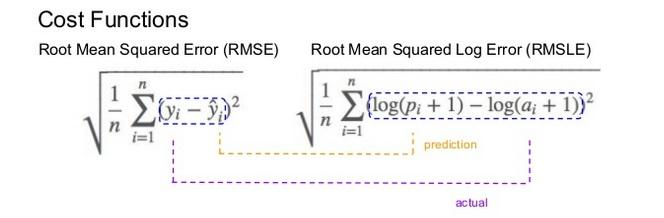

In [ ]:
plt.figure(figsize = (6, 6))
pd.DataFrame(importance_xgb, columns = X.columns).apply(np.mean, axis = 0).sort_values().plot(kind = 'barh');
plt.xlabel('Feature importance score')
plt.ylabel('Features')
plt.show(); 

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left">

<h3 align="left"><font color='#DEB887'>💡 Insights:</font></h3>

* As we skipped feature engineering process, this result might be different once you apply scaling and other feature engineering methods.
* The average RMSE over 3-folds (run 3 times) is: 0.304 , this is slightly better than benchmark.

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left">

<h3 align="left"><font color='#DEB887'>✔️ Conclusion:</font></h3>

 😊 this is a simple baseline for beginners. you can 1) adjust hyper-parameter (HP tuning) ; 2) try different algorithms ; 3) add more feature engineered data to improve the performance.
